In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0,'..')
import matplotlib.pyplot as plt
import os.path
import prepare
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(16,10))
plt.rc('font', size=14)
pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_columns', 50)

In [2]:
if os.path.isfile('sso_dict.csv'):
    df_dict = pd.read_csv('sso_dict.csv')
else:
    url_sso_dict = '''https://storage.googleapis.com/sa_saws_data/SAWS_SSO_DataFieldDescription_MM.xlsx'''
    df_dict = pd.read_excel(url_sso_dict)
    df_dict.to_csv('sso_dict.csv', index=False)

In [3]:
df_dict

,Field,Data Description
0,SSO_ID,Internal ID
1,INSPKEY,Not Used
2,SERVNO,Service Req # (internal use only)
3,REPORTDATE,Date Reported
4,SPILL_ADDRESS,Street number of spill
5,SPILL_ST_NAME,Streen name of spill
6,TOTAL_GAL,Total gallons spilled
7,GALSRET,Gallons returned to collection system
8,GAL,Disregard
9,SPILL_START,When SAWS received information about the spill or arrived at the location


In [4]:
# df = acquire_sso.acquire_sso()

In [5]:
# df.head(1)

In [6]:
# df = prepare_sso.prepare_sso_df()
# df.head(1)

In [7]:
# df = prepare.prepare_sso_df()
# print(df.shape[0])
# df.head(1)

In [8]:
# df.columns = ['sso_id','report_date','spill_address_num','spill_st_name',
#  'total_gal','gals_ret','spill_start','spill_stop','hrs','cause',
#  'comments','actions','watershed','unit_id','unit_id2','discharge_to',
#  'discharge_route','council_district','month','year','week',
#  'earz_zone','pipe_diam','pipe_len','pipe_type','inst_year','inches_no',
#  'rainfall_last3','spill_address_full','num_spills_recorded',
#  'num_spills_24mos','prevspill_24mos','unit_type','asset_type',
#  'last_cleaned','response_time','response_dttm','public_notice',
#  'root_cause','hrs_2','gal_2','hrs_3','gal_3','days_since_cleaned']

In [9]:
# df.head(1)

In [10]:
# df.ResponseTime * 60

In [11]:
# df.shape

In [12]:
# df_dict.shape

In [13]:
# df_dict['Data Description'].value_counts()

In [14]:
# unused = ['Disregard','Ignore','Service Req # (internal use only)',
#           'Not Used','Old mapping system reference (internal only)']
# df_dict[df_dict['Data Description'].isin(unused)]

In [15]:
# ready1_dict = df_dict[~df_dict['Data Description'].isin(unused)]
# print(len(ready1_dict))
# ready1_dict

In [16]:
# null_fields = ['SPILL_START_2','SPILL_START_3',
#                'SPILL_STOP_2','SPILL_STOP_3']
# final_dict = ready1_dict[~ready1_dict.Field.isin(null_fields)]\
#                     .reset_index(drop=True)
# len(final_dict)

In [17]:
# final_dict

In [18]:
# features_to_use = list(final_dict.Field)
# len(features_to_use)

In [19]:
# bad_features = list(df.columns[~df.columns.isin(features_to_use)])

In [20]:
# df = df.drop(columns=bad_features)
# df = df.drop(columns = ['TIMEINT','STEPS_TO_PREVENT'])
# df.shape

In [21]:
# string_features = ['SSO_ID','SPILL_ADDRESS','COUNCIL_DISTRICT',]
# for col in string_features:
#     df[col] = df[col].astype(str)
    
# time_features = ['REPORTDATE','SPILL_START','SPILL_STOP',
#                  'ResponseDTTM', 'LASTCLND']
# for col in time_features:
#     df[col] = pd.to_datetime(df[col])
    
# fill_features = ['NUM_SPILLS_24MOS','PREVSPILL_24MOS','HRS_2',
#                 'HRS_3','GAL_2','GAL_3']
# for col in fill_features:
#     df[col] = df[col].fillna(0)
    
# df.Root_Cause = df.Root_Cause.str.strip()

In [22]:
# df['days_since_cleaned'] = (df.SPILL_START - df.LASTCLND).dt.days

In [23]:
# df['country_address'] = df.spill_address_full + \
#                                   ',SAN ANTONIO,Texas,USA'
# df.country_address

In [24]:
# df[['country_address']].head(25)

In [25]:
# for i in range(df.index.max()//5):
#     print([1*i+5, 2*i+5, 3*i + 5])

In [26]:
# lmo = pd.DataFrame()
# lmo['loc'] = ['string','fnish']
# lmo['was'] = [2,3]
# lmo.was[1] = 4
# lmo

In [27]:
# locator = Nominatim(user_agent="myGeocoder")
# geocode = RateLimiter(locator.geocode, min_delay_seconds=.1)
# test2 = pd.Series()

# counter = 10
# for i in range(0, df.index.max(), 10):
#     test = df[['country_address']][i:counter]
#     test['location'] = test['country_address'].apply(geocode)
#     test['zip_code'] = 'None'
#     for t,l in enumerate(test.location):
#         if l is not None:
#             test['zip_code'][counter+t-10] = l.raw['display_name']\
#                                     .split(',')[-2]
#     time.sleep(2)
#     test2 = test2.append(test.zip_code)
#     counter+=10
# test2

### Working

In [28]:
# locator = Nominatim(user_agent="myGeocoder")
# geocode = RateLimiter(locator.geocode, min_delay_seconds=.1, 
#                      max_retries=10, error_wait_seconds=1)
# df['location'] = df['country_address'].apply(geocode)
# df['zip_code'] = 'None'

In [29]:
# for t,l in enumerate(df.location):
#         if l is not None:
#             df['zip_code'][t] = l.raw['display_name']\
#                                     .split(',')[-2]

In [30]:
# df = prepare.prepare_sso_with_zipcodes()
# print(df.shape[0])
# df.head(1)

# Exploration

In [31]:
df = prepare.get_data()

df.age = df.age.replace(np.NaN, 'unknown')

print(df.shape)
df.head(1)

(3183, 75)


,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
0,6582,2019-03-10,3200,THOUSAND OAKS DR,2100,2100.0,2019-03-10 13:16:00,2019-03-10 14:40:00,1.4,Grease,"Spill ContainedReturned to SystemArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,",CLEANED MAIN,SALADO CREEK,66918,66917,STREET,None,NaN,3,2019,11,0,8.0,16.55,PVC,...,1.4,0.0,0.0,0.0,69.0,79,60,1,1,0,0,0,0,0.004286,0.005714,0.016333,54.285714,55.285714,54.2,65.857143,65.714286,64.533333,46.0,47.642857,45.9


In [32]:
train, test = train_test_split(df, random_state=42, train_size=.8)

In [33]:
train.zip_code.value_counts().head(5)

None     754
Texas    223
78228    110
78223     94
78218     75
Name: zip_code, dtype: int64

In [34]:
train.isna().sum()

sso_id                 0
report_date            0
spill_address_num      0
spill_st_name          0
total_gal              0
                      ..
max_temp_rolling_14    0
max_temp_rolling_30    0
min_temp_rolling_7     0
min_temp_rolling_14    0
min_temp_rolling_30    0
Length: 75, dtype: int64

In [35]:
train.spill_address_full.head(15)

3142                                          W ASHBY PLACE 02947
533                                               7450 Saddlewood
2615                                               13616 Primwood
2605                                                   207 OCONEE
1749                                                223 HOT WELLS
2505                                           5251 TIMBERHILL DR
2540                                                167 Shoreview
2250    9206 Oak Downs (Over The Edwards Aquifer Transition Zone)
1537                                                 4606 AMISTAD
695                                       CHAPPIE JAMES WAY 00108
3020                                                          NaN
637                                          HUISACHE AVE W 00602
765                                           ELKHORN RIDGE 29621
682                                                     4567 Lark
1953                                              2902 GOLIAD RD.
Name: spil

In [36]:
train.days_since_cleaned.dropna()

2615     86.0
2605     57.0
1749      3.0
2505      4.0
2540      3.0
        ...  
2324    334.0
2853    175.0
2135    520.0
1095     -1.0
1294     21.0
Name: days_since_cleaned, Length: 900, dtype: float64

In [37]:
train[train.days_since_cleaned == train.days_since_cleaned.max()]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
1020,3555,2015-02-23,3,VILLA VERDE,200,0.0,2015-02-23 15:28:00,2015-02-23 16:46:00,1.3,Grease,"Spill ContainedArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,",CLEANED MAIN,DOS RIOS,6169,6157,DRAINAGE CULVERT,None,8.0,2,2015,9,0,8.0,400.0,VCP,...,1.3,0.0,0.0,0.0,39.0,41,32,0,0,0,0,0,0,1.055703e-16,0.005714,0.022333,53.857143,57.214286,56.2,65.0,68.142857,67.433333,42.571429,45.357143,45.233333


In [38]:
features = df.isna().sum() / df.shape[0]
bad_list = features[features > .4]
print(len(bad_list))
bad_list

4


last_cleaned          0.654100
response_time         0.607603
response_dttm         0.607603
days_since_cleaned    0.654100
dtype: float64

In [40]:
train.drop(columns='hours_spilled')\
    .describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,sso_id,spill_address_num,total_gal,gals_ret,hrs,council_district,month,year,week,pipe_diam,pipe_len,inches_no,rainfall_last3,num_spills_recorded,num_spills_24mos,response_time,hrs_2,gal_2,hrs_3,gal_3,days_since_cleaned,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
count,2546.000000,2546.000000,2546.000000,2166.000000,2544.000000,2285.000000,2546.000000,2546.000000,2546.000000,2386.000000,2386.000000,2169.000000,2119.000000,2546.000000,2546.000000,979.000000,2546.000000,2546.000000,2546.000000,2546.000000,900.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000
mean,3291.047918,4243.565200,33885.702671,2971.348107,4.537969,5.009190,6.183425,2012.842891,25.594658,11.362741,286.820522,0.484329,0.524153,1.937942,0.729772,28.888253,0.243886,4080.334643,0.020185,87.562844,263.175556,0.425797,0.001414,0.000786,68.264140,78.859780,58.226630,0.391987,0.040848,0.167321,0.086803,0.010998,0.171249,0.190219,0.144637,0.120704,68.557148,68.639462,68.628456,79.263438,79.437942,79.499476,58.448491,58.470963,58.362962
std,1853.418506,4629.598227,335392.681816,38236.663491,42.376776,3.045827,3.587981,2.913768,15.663250,10.164595,438.145865,1.300454,1.117866,2.094074,1.218083,291.101563,2.975505,67694.762188,0.400305,1950.316719,300.654207,1.217283,0.040599,0.039637,13.509956,13.827266,14.493549,0.488290,0.197978,0.373336,0.281601,0.104312,0.376800,0.310362,0.184731,0.112929,12.899900,12.730783,12.464758,12.967545,12.746314,12.467355,13.598593,13.334865,12.970327
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2009.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-8550.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,24.000000,28.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.285714,42.178571,46.500000,47.142857,50.000000,55.333333,25.000000,26.642857,33.700000
25%,2089.250000,700.000000,50.000000,0.000000,0.750000,2.000000,3.000000,2010.000000,11.250000,8.000000,138.475000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.000000,0.000000,0.000000,0.000000,58.000000,70.000000,47.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010714,0.031667,57.571429,57.285714,56.670833,69.607143,69.071429,68.550000,46.428571,46.214286,46.233333
50%,2881.500000,2520.000000,225.000000,0.000000,1.375000,5.000000,6.000000,2012.000000,24.000000,8.000000,266.430000,0.000000,0.000000,1.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,162.500000,0.000000,0.000000,0.000000,70.000000,80.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.067143,0.089667,69.857143,69.000000,69.333333,80.214286,80.214286,80.300000,59.285714,58.928571,58.766667
75%,3752.750000,6618.750000,2500.000000,0.000000,2.783333,8.000000,9.000000,2015.000000,40.000000,8.000000,354.120000,0.120000,0.460000,2.000000,1.000000,54.000000,0.000000,0.000000,0.000000,0.000000,375.250000,0.050000,0.000000,0.000000,79.000000,89.000000,71.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.270000,0.231429,0.171667,79.714286,79.821429,79.462500,89.571429,90.053571,90.066667,71.285714,71.142857,70.033333
max,6584.000000,29621.000000,13304550.000000,1320000.000000,1796.000000,10.000000,12.000000,2019.000000,53.000000,66.000000,11689.350000,9.870000,12.270000,21.000000,13.000000,907.000000,118.000000,2377350.000000,15.530000,66000.000000,

In [41]:
len(train.report_date.unique())

1620

In [42]:
train[train.num_spills_recorded == train.num_spills_recorded.max()]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
800,5774,2015-12-22,5704,PRESA ST S,90,NaN,2015-12-21 11:16:00,2015-12-21 18:00:00,6.733333,Structural,"Repaired main, 10"" sewer main",REPAIRED MAIN,DOS RIOS,NaN,NaN,DRAINAGE CULVERT,NONE,3.0,12,2015,52,0,NaN,NaN,NaN,...,6.733333,0.0,0.0,0.0,62.0,79,48,0,0,0,0,0,0,3.172066e-16,0.052857,0.102333,56.857143,60.285714,57.666667,69.142857,72.928571,69.466667,43.857143,47.571429,46.000000
71,6512,2018-11-13,606,N ALAMO ST,2080,0.0,2018-11-13 08:16:00,2018-11-13 10:00:00,1.733333,Contractor,NaN,REMOVED BYPASS,DOS RIOS,STMDRAIN,NaN,STORMDRAIN - Then entered the San Antonio River,SAN ANTONIO RIVER,NaN,11,2018,46,0,NaN,NaN,NaN,...,1.733333,0.0,0.0,0.0,40.0,48,28,0,0,0,0,0,0,2.300000e-01,0.182857,0.202667,55.428571,60.214286,60.866667,59.857143,67.642857,69.166667,47.714286,51.000000,52.866667
716,5863,2016-04-23,4006,BRIARGLEN,6000,NaN,2016-04-22 21:00:00,2016-04-22 23:00:00,2.000000,Other,NaN,REPAIRED PUMP,SALADO CREEK,46429,46423,CREEK BED - SPILLED INTO BEITEL CREEK,BEITEL CREEK,NaN,4,2016,17,0,NaN,NaN,NaN,...,2.000000,0.0,0.0,0.0,70.0,81,56,0,0,0,0,0,0,3.785714e-01,0.358571,0.172667,71.428571,70.142857,67.300000,80.428571,79.642857,78.000000,62.714286,62.285714,56.866667


In [43]:
train[train.total_gal.isin(list(train.total_gal.nlargest(8)))]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
647,5943,2016-06-02,6606,SWISS OAKS,2050500,0.0,2016-06-02 11:45:00,2016-06-06 12:30:00,96.75,I/I,NaN,DILUTED BY HEAVY RAINWATER,LEON CREEK,903064,903061,CREEK BED - SPILLED INTO LEON CREEK,LEON CREEK,6.0,6,2016,23,0,0.0,16.81,,...,96.750000,2.34,0.0,0.0,74.0,85,66,1,0,1,0,0,0,0.941429,0.471429,0.382333,77.285714,77.500000,75.166667,88.000000,87.071429,84.566667,67.285714,69.928571,67.100000
84,6499,2018-10-24,108,CHAPPIE JAMES WAY,2448400,0.0,2018-10-24 13:50:00,2018-10-28 13:29:00,95.65,I/I,NaN,MONITORED AREA,LEON CREEK,1210,42319,CREEK BED - Spilled Into Leon Creek,LEON CREEK,NaN,10,2018,43,0,54.0,1335.00,RCP,...,95.650000,0.79,0.0,0.0,59.0,63,55,1,0,0,0,0,0,0.282857,0.254286,0.185333,60.000000,62.928571,70.533333,65.571429,70.000000,78.100000,55.428571,57.428571,64.700000
115,6466,2018-09-20,6606,SWISS OAKS,13304550,0.0,2018-09-20 09:45:00,2018-11-19 01:30:00,620.07,I/I,NaN,MONITORED AREA,LEON CREEK,903059,71380,CREEK BED - Spilled Into Leon Creek,LEON CREEK,6.0,9,2018,38,0,42.0,1301.00,RCP,...,1431.750000,0.56,0.0,0.0,80.0,87,74,1,0,1,0,0,0,0.512857,0.545000,0.498667,78.142857,77.714286,81.633333,86.428571,85.642857,91.900000,72.857143,72.785714,74.400000
2338,18,2010-10-20,8600,MISSION PKWY,4442000,NaN,2010-10-20 09:00:00,2010-10-27 11:00:00,170.00,Break In Main,REPAIRED FORCE MAIN - L/S # 172,REPAIRED BROKEN MAIN,DOS RIOS,13440,14063,CREEK BED,SAN ANTONIO RIVER,3.0,10,2010,43,0,30.0,122.58,FRP,...,170.000000,0.00,0.0,0.0,74.0,85,63,0,0,0,0,0,0,0.000000,0.006429,0.017667,69.857143,70.285714,72.083333,82.857143,83.428571,84.200000,56.857143,57.142857,59.966667
653,5922,2016-05-31,108,CHAPPIE JAMES WAY,2453340,0.0,2016-05-31 17:08:00,2016-06-01 07:02:00,13.90,I/I,NaN,DILUTED BY HEAVY RAINWATER,LEON CREEK,1187,1074,CREEK BED - SPILLED INTO LEON CREEK,LEON CREEK,NaN,5,2016,23,0,54.0,17.61,CSC,...,13.900000,1.84,0.0,0.0,77.0,85,67,1,0,1,0,0,0,0.607143,0.447857,0.304333,79.285714,76.714286,74.633333,89.142857,85.928571,83.866667,70.285714,69.285714,66.466667
688,5888,2016-05-18,700,HOLBROOK,2754790,0.0,2016-05-17 18:28:00,2016-05-21 03:00:00,80.53,I/I,NaN,DILUTED BY HEAVY RAINWATER,SALADO CREEK,990827,48236,CREEK BED - Spilled Into Salado Creek,SALADO CREEK,2.0,5,2016,21,0,0.0,0.00,,...,80.533333,0.14,0.0,0.0,71.0,78,63,0,0,1,0,0,0,0.292857,0.214286,0.155333,73.285714,73.928571,73.000000,79.857143,82.500000,82.466667,67.000000,65.714286,63.666667
504,6062,2016-12-03,108,CHAPPIE JAMES WAY,1880100,0.0,2016-12-03 09:24:00,2016-12-04 09:00:00,23.60,I/I,NaN,Diluted By Heavy Rain Water,LEON CREEK,462766,1210,CREEK BED - Spilled Into Leon Creek,LEON CREEK,0.0,12,2016,49,0,54.0,17.18,CSC,...,23.600000,3.84,0.0,0.0,53.0,53,50,1,0,1,0,0,0,0.642857,0.321429,0.207667,60.857143,60.785714,63.833333,70.142857,71.642857,73.933333,49.285714,49.500000,53.933333
646,5942,2016-06-02,700,HOLBROOK,6026731,0.0,2016-06-02 11:09:00,2016-06-06 07:30:00,92.35,I/I,NaN,DILUTED BY HEAVY RAINWATER,SALADO CREEK,47822,922726,CREEK BED - SPILLED INTO SALADO CREEK,SALADO CREEK,2.0,6,2016,23,0,0.0,5.89,,...,92.350000,2.34,0.0,0.0,74.0,85,66,1,0,1,0,0,0,0.941429,0.471429,0.382333,77.285714,77.500000,75.166667,88.000000,87.071429,84.566667,67.285714,69.928571,67.100000


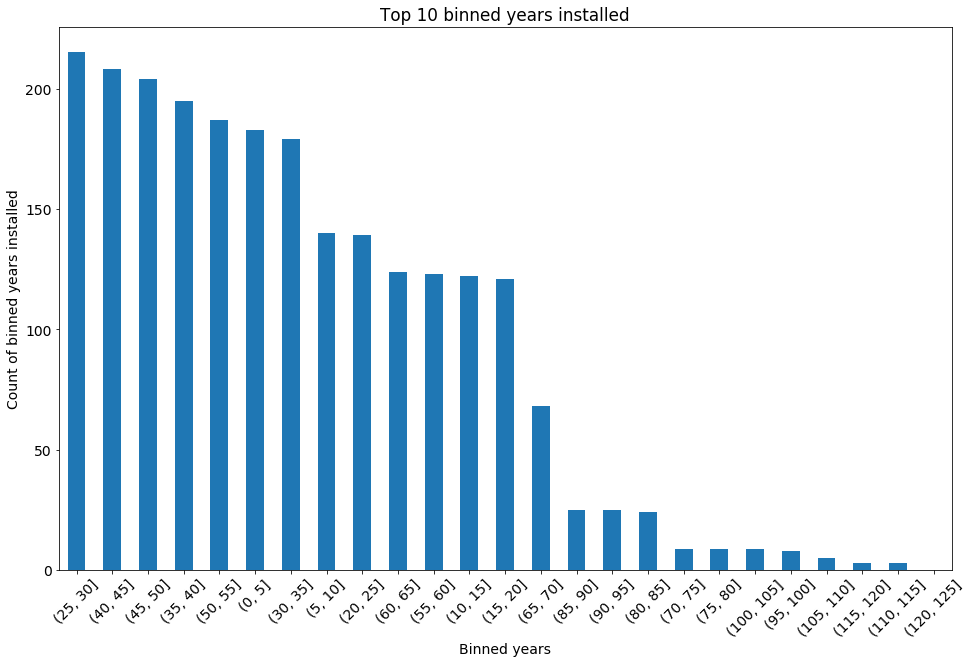

In [44]:
train.age_binned.dropna().value_counts().plot.bar()
plt.xticks(rotation=45)

plt.ylabel('Count of binned years installed')
plt.xlabel('Binned years')
plt.title('Top 10 binned years installed')
plt.show()

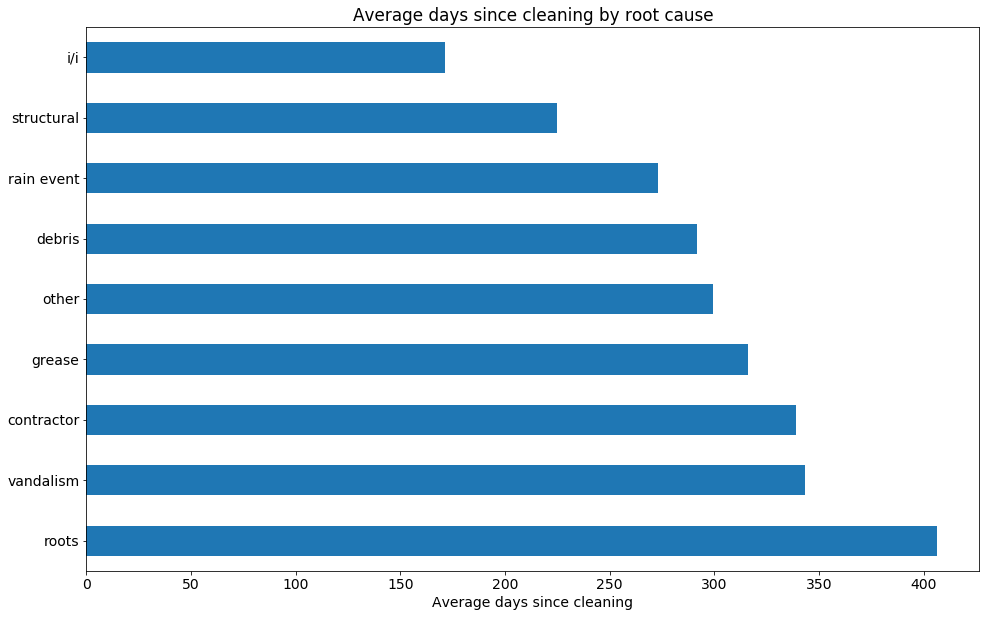

In [45]:
ax = train.groupby('root_cause').days_since_cleaned.mean()\
    .sort_values(ascending=False).dropna().plot.barh()
ax.set_ylabel('')
ax.set_xlabel('Average days since cleaning')
plt.title('Average days since cleaning by root cause')
plt.show()

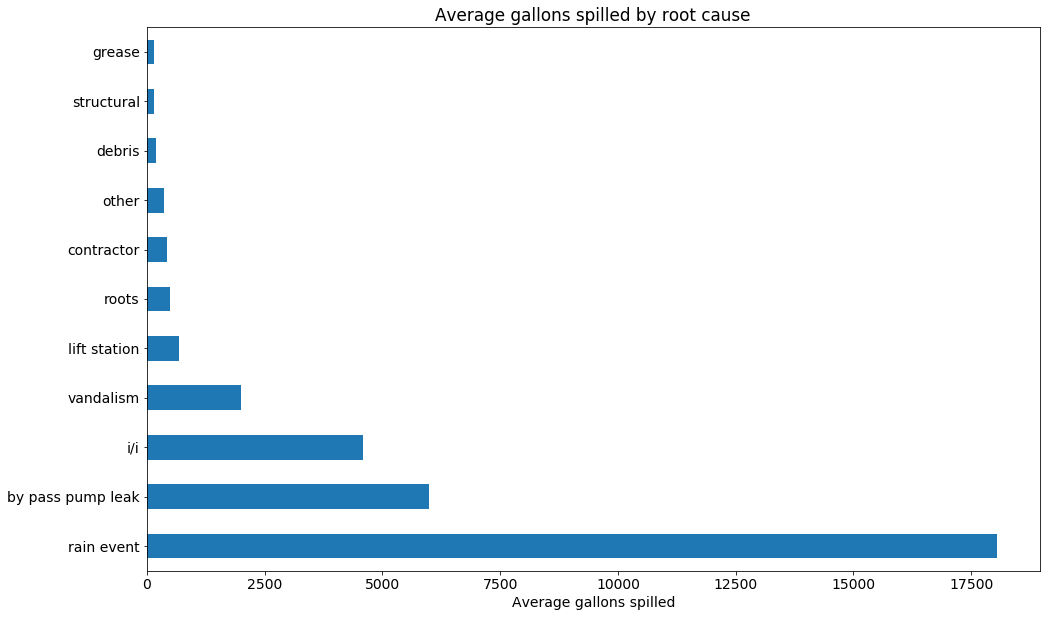

In [46]:
ax = train.groupby('root_cause').total_gal.median()\
    .sort_values(ascending=False).dropna().plot.barh()
ax.set_ylabel('')
ax.set_xlabel('Average gallons spilled')
plt.title('Average gallons spilled by root cause')
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

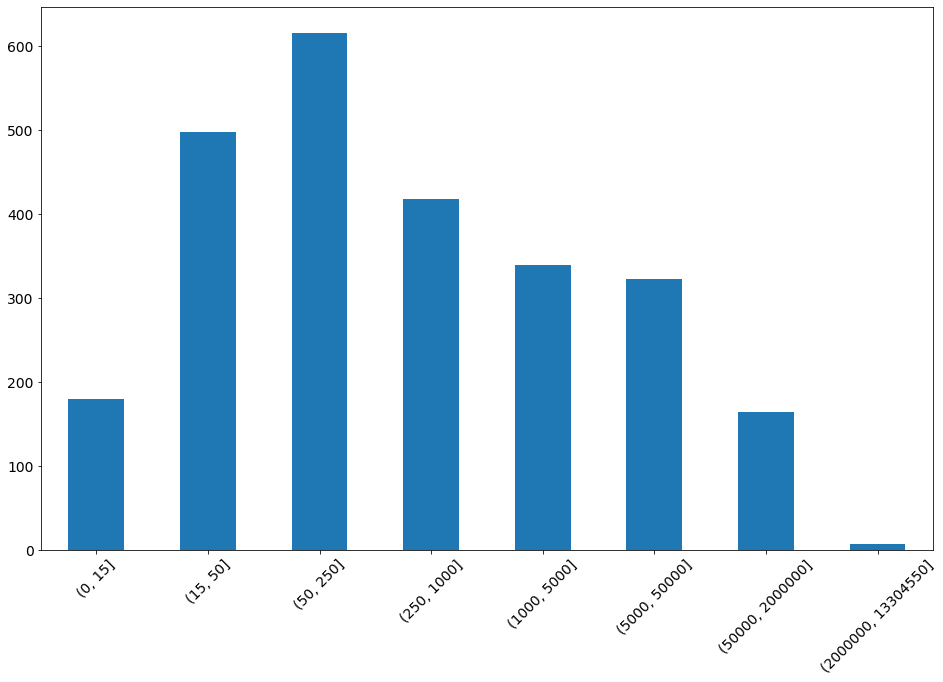

In [47]:
train['total_gal_binned'].value_counts().sort_index().plot.bar()
plt.xticks(rotation=45)

In [48]:
train[train.days_since_cleaned == train.days_since_cleaned.max()]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
1020,3555,2015-02-23,3,VILLA VERDE,200,0.0,2015-02-23 15:28:00,2015-02-23 16:46:00,1.3,Grease,"Spill ContainedArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,",CLEANED MAIN,DOS RIOS,6169,6157,DRAINAGE CULVERT,None,8.0,2,2015,9,0,8.0,400.0,VCP,...,1.3,0.0,0.0,0.0,39.0,41,32,0,0,0,0,0,0,1.055703e-16,0.005714,0.022333,53.857143,57.214286,56.2,65.0,68.142857,67.433333,42.571429,45.357143,45.233333


In [49]:
train[train.inst_year == train.inst_year.max()].shape

(104, 75)

In [50]:
train.groupby('inst_year').total_gal.median()\
    .sort_values(ascending=False)

inst_year
1973.0    9300.0
1910.0    9200.0
1930.0    6197.5
1933.0    6000.0
1990.0    5625.0
           ...  
1941.0      40.0
1923.0      27.5
1945.0      22.5
1918.0      20.0
1912.0      10.0
Name: total_gal, Length: 103, dtype: float64

In [51]:
train.root_cause.value_counts()

structural           979
grease               492
debris               361
rain event           324
contractor           132
lift station         117
vandalism             54
other                 51
roots                 17
i/i                   10
by pass pump leak      3
Name: root_cause, dtype: int64

In [52]:
train.head(1)

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
3142,350,2009-02-12,2947,ASHBY PLACE W,500,NaN,2009-02-12 10:30:00,2009-02-12 14:00:00,3.5,Rags,CLEANED MAIN,APPLIED HTH,DOS RIOS,32298,32299,DRAINAGE CULVERT,none,7.0,2,2009,7,0,8.0,373.0,CT,...,3.5,0.0,0.0,0.0,60.5,79,42,0,0,0,0,0,0,0.084286,0.042143,0.021667,66.714286,61.0,57.25,79.428571,75.714286,71.9,54.0,46.285714,42.6


In [53]:
top_worst_spills = train[train.total_gal.isin(
                            train.total_gal.nlargest(15))]
top_worst_spills[['age_binned','total_gal']]\
    .sort_values('total_gal', ascending=False)

,age_binned,total_gal
115,"(40.0, 45.0]",13304550
646,"(40.0, 45.0]",6026731
2338,"(15.0, 20.0]",4442000
688,"(0.0, 5.0]",2754790
653,"(30.0, 35.0]",2453340
84,"(50.0, 55.0]",2448400
647,"(0.0, 5.0]",2050500
504,"(30.0, 35.0]",1880100
112,"(50.0, 55.0]",1640538
517,"(40.0, 45.0]",1560928


In [54]:
top_bins = top_worst_spills.sort_values(by='total_gal', 
                        ).age_binned.value_counts()
top_bins[top_bins>0]

(50, 55]    4
(0, 5]      3
(30, 35]    3
(40, 45]    3
(15, 20]    1
Name: age_binned, dtype: int64

In [55]:
train.groupby('age_binned').total_gal.mean()\
            .dropna().sort_values().tail(6)

age_binned
(35, 40]     15606.625641
(15, 20]     44291.454545
(30, 35]     56858.418994
(50, 55]     56954.625668
(0, 5]       57772.306011
(40, 45]    150559.033654
Name: total_gal, dtype: float64

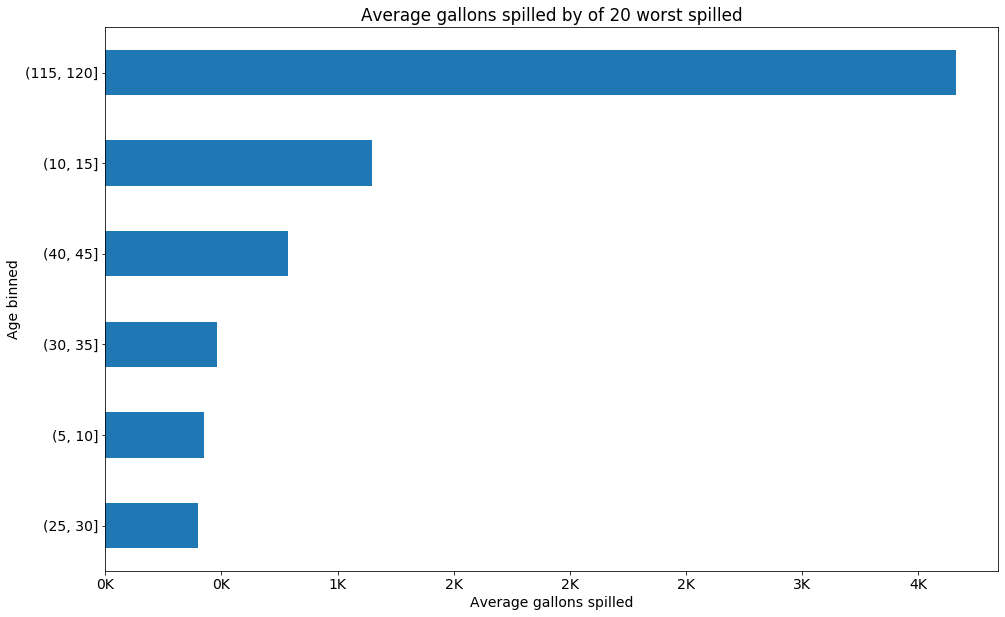

In [56]:
ax = train.groupby('age_binned').total_gal.median()\
            .dropna().sort_values().tail(6).plot.barh()
xlabels = ['{:,.0f}'.format(x) +'K' 
                   for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
ax.set_xlabel('Average gallons spilled')
ax.set_ylabel('Age binned')
plt.title('Average gallons spilled by of 20 worst spilled')
plt.show()

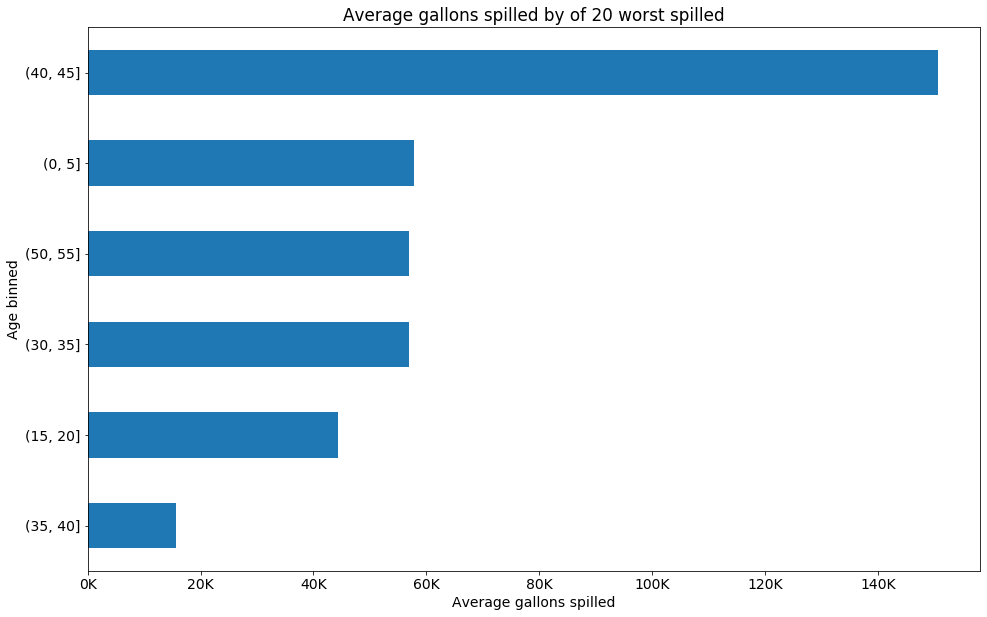

In [57]:
ax = train.groupby('age_binned').total_gal.mean()\
            .dropna().sort_values().tail(6).plot.barh()
xlabels = ['{:,.0f}'.format(x) +'K' 
                   for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
ax.set_xlabel('Average gallons spilled')
ax.set_ylabel('Age binned')
plt.title('Average gallons spilled by of 20 worst spilled')
plt.show()

## Make data useable for modeling

In [159]:
df.inst_year = df.inst_year[df.inst_year!='unknown']

In [164]:
df.last_cleaned.value_counts()

2009-09-23 00:00:00    6
2009-08-22 00:00:00    5
2012-05-11 00:00:00    5
2009-10-22 00:00:00    5
2012-02-29 00:00:00    4
                      ..
2010-05-24 00:00:00    1
2013-11-25 12:01:00    1
2014-03-15 20:00:00    1
2009-07-27 00:00:00    1
2013-12-02 14:52:00    1
Name: last_cleaned, Length: 814, dtype: int64

In [156]:
list(df.dtypes[df.dtypes=='O'].index)

['spill_st_name',
 'cause',
 'comments',
 'actions',
 'watershed',
 'unit_id',
 'unit_id2',
 'discharge_to',
 'discharge_route',
 'earz_zone',
 'pipe_type',
 'inst_year',
 'spill_address_full',
 'prevspill_24mos',
 'unit_type',
 'asset_type',
 'last_cleaned',
 'root_cause',
 'country_address',
 'location',
 'zip_code',
 'age']

In [166]:
unwanted = ['spill_st_name','comments','actions','discharge_to',
           'discharge_route','spill_address_full','prevspill_24mos',
           'last_cleaned','country_address','location']
categorical_columns = [col for col in list(
                df.dtypes[df.dtypes=='O'].index) 
                 if col not in unwanted]

In [167]:
for column in categorical_columns:
    if is_numeric_dtype(df[f"{column}"]):
        values = df[f"{column}"].unique()
        for value in values:
            df[f"{column}_is_{value}"] = (df[f"{column}"] == value).astype(int)
        df = df.drop(columns=column)
    elif is_string_dtype(df[f"{column}"]):
        values = df[f"{column}"].astype(str).str.lower().unique()
        for value in values:
            df[f"{column}_is_{value}"] = (df[f"{column}"] == value).astype(int)
        df = df.drop(columns=column)

NameError: name 'is_numeric_dtype' is not defined

In [143]:
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(sparse=False, categories='auto')
# train_ohe = ohe.fit(train[['cause']])
# train_ohe = ohe.transform(train[['cause']])
# test_ohe = ohe.transform(test[['cause']])
# train_encoded = pd.DataFrame(data=train_ohe,
#                         columns=encoded_values, index=train.index)
# train = train.join(train_encoded)

# test_encoded = pd.DataFrame(data=test_ohe,
#                         columns=encoded_values, index=test.index)
# test = test.join(test_encoded)

In [107]:
X_train = train.drop(columns=['root_cause','report_date',
                'spill_start','spill_stop','response_dttm',
                'total_gal_binned','age_binned','spill_st_name',
                'comments','discharge_to','discharge_route',
                'spill_address_full','country_address','location'])
y_train = train.root_cause

In [109]:
train.age_binned = train.age_binned.astype(str)
train.total_gal_binned = train.total_gal_binned.astype(str)

In [110]:
train.age_binned[0:1]

3142    (85.0, 90.0]
Name: age_binned, dtype: object

In [111]:
# from datetime import timedelta
# train.time_spilled / timedelta (hours=1)

In [112]:
# list(X_train.dtypes)

In [113]:
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression(random_state = 42).fit(X_train, y_train)
# y_pred = model.predict(X_train)
# y_pred_prob = model.predict_proba(X_train)
# model.score(X_train, y_train)

In [114]:
# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier(random_state=42, min_samples_leaf = 1,
#                             max_depth = 8).fit(X_train, y_train)
# rf.score(X_train, y_train)

In [115]:
from sklearn.neighbors import KNeighborsClassifier
rf = KNeighborsClassifier().fit(X_train, y_train)
rf.score(X_train, y_train)


ValueError: could not convert string to float: 'Rags'